In [192]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as pyo
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


In [311]:
df= pd.read_excel('Dataset.xlsx')

# 将数据保存为CSV文件
df.to_csv('train.csv', index=False)

# 删除全是0的列
data = df.loc[:, (df != 0).any(axis=0)]

missing_percentage = data.isnull().sum() / len(data)

# 找出缺失值超过 60% 的列
columns_to_drop = missing_percentage[missing_percentage > 0.6].index.tolist()

data.drop(columns_to_drop, axis=1, inplace=True)


In [312]:

# 随机森林回归模型迭代填补缺失值
missing_value_columns = data.columns[data.isnull().any()].tolist()

imputer = IterativeImputer(RandomForestRegressor(), max_iter=20, random_state=42)
data[missing_value_columns] = imputer.fit_transform(data[missing_value_columns])

d:\anaconda\lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [313]:
# 替换指定列中的“ND”为np.nan
data['EDC_delta13C'] = data['EDC_delta13C'].replace('ND', np.nan)
data['PCE_delta13C'] = data['PCE_delta13C'].replace('ND', np.nan)

data.dropna(subset=['EDC_delta13C'], inplace=True)


C:\Users\jia\AppData\Local\Temp\ipykernel_13360\2381158466.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

C:\Users\jia\AppData\Local\Temp\ipykernel_13360\2381158466.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [367]:
# 创建随机森林回归器实例
rf = RandomForestRegressor(
    n_estimators=35,      # 树的数量
    max_depth=4,           # 树的最大深度
    min_samples_split=8,  # 分割内部节点所需的最小样本数
    min_samples_leaf=4,    # 在叶节点上所需的最小样本数
    max_features='sqrt',   # 查找最佳分割时要考虑的特征数量，这里设置为特征数的平方根
    bootstrap=True,        # 使用样本的自助采样
    oob_score=True,        # 使用袋外样本来估计R²分数
    random_state=42,       # 控制模型的随机性
)
# {35,4,8,4}

# 特征：数据集中除了名为 'EDC_delta13C' 的列的所有列
X = data.drop(['EDC_delta13C','PCE_delta13C','Depth','ID'], axis=1)

# 标签：数据集中名为 'EDC_delta13C' 的列
y = data['EDC_delta13C']

# 2/8分划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 使用训练数据拟合模型
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_
feature_names = X.columns
print(len(feature_names))
print(len(feature_importances))

feature_scores = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# 打印特征按重要性排序
print(feature_scores.sort_values(by='Importance', ascending=False))


5402
5402
                                                Feature  Importance
4467                                    Trichloroethene    0.082712
4438                                       Bromomethane    0.080479
4415                              Bacterial_gene_copies    0.068871
3109  k__Bacteria; p__Bacteroidetes; c__[Saprospirae...    0.056084
4469                         "trans-1,2-dichloroethene"    0.042769
...                                                 ...         ...
1806  k__Bacteria; p__Elusimicrobia; c__; o__; f__; ...    0.000000
1805                                    Unclassified.89    0.000000
1804  k__Bacteria; p__WS3; c__PRR-12; o__Sediment-1;...    0.000000
1803  k__Bacteria; p__Chlorobi; c__Ignavibacteria; o...    0.000000
5401  D_0__Bacteria;D_1__Planctomycetes;D_2__Plancto...    0.000000

[5402 rows x 2 columns]


In [368]:
from sklearn.metrics import mean_squared_error, r2_score

# 计算训练集的预测结果
y_train_pred = rf.predict(X_train)

# 计算测试集的预测结果
y_test_pred = rf.predict(X_test)

# 计算训练集的性能指标
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# 计算测试集的性能指标
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# 打印训练集的性能指标
print("Training set model performance:")
print("Train MSE:", train_mse)
print("Train (RMSE):", train_rmse)
print("Train R² score:", train_r2)
print("-----------------------------------")
print("          ")
# 打印测试集的性能指标
print("Test set model performance:")
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R² score:", test_r2)


Training set model performance:
Train MSE: 21.72459823099533
Train (RMSE): 4.660965375434078
Train R² score: 0.5058854876856519
-----------------------------------
          
Test set model performance:
Test MSE: 27.115154854194202
Test RMSE: 5.207221413978304
Test R² score: 0.28199958490365185


In [371]:
import pandas as pd

# 按重要性排序，选择前30个
top_30_features = feature_scores.sort_values(by='Importance', ascending=False).head(30)

# 提取前30个最重要的特征的名称
top_30_feature_names = top_30_features['Feature'].values

# 使用这些特征来创建新的训练数据集
X_train_top30 = X[top_30_feature_names]

X_trains, X_tests, y_train, y_test = train_test_split(X_train_top30, y, test_size=0.2, random_state=42)
# 可以用这个新的特征集来重新训练模型或进行其他分析
rf.fit(X_trains, y_train)

# 训练集预测
y_train_pred = rf.predict(X_trains)

# 测试集预测
y_pred = rf.predict(X_tests)

y_test_pred = rf.predict(X_tests)

# 计算训练集的MSE, RMSE, R²
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

# 计算测试集的MSE, RMSE, R²
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# 输出结果
print("Training set model performance:")
print(f"Train MSE: {train_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Train R² score: {train_r2}")
print("-----------------------------------")
print("Test set model performance:")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² score: {test_r2}")

Training set model performance:
Train MSE: 17.673184739319506
Train RMSE: 4.203948707979143
Train R² score: 0.5980327476873137
-----------------------------------
Test set model performance:
Test MSE: 21.46170639584325
Test RMSE: 4.6326781019021
Test R² score: 0.4317010474860761


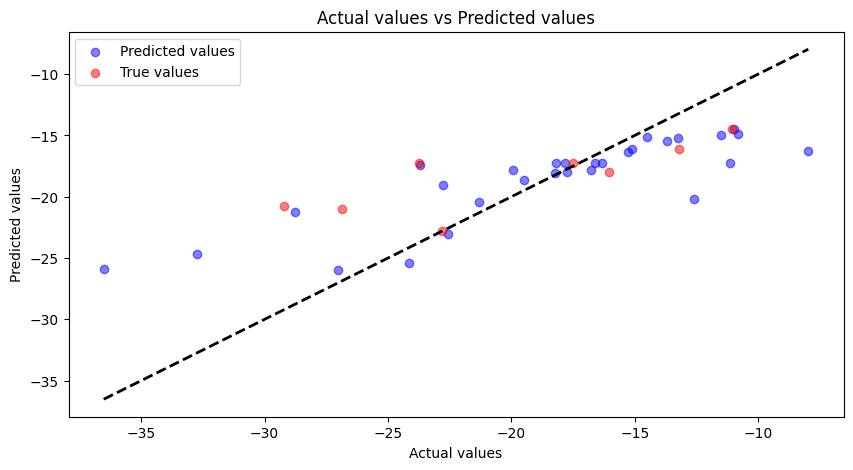

In [372]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个图形和轴
plt.figure(figsize=(10, 5))

# 绘制训练数据的散点图
plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5, label='Predicted values')
# 绘制测试数据的散点图
plt.scatter(y_test, y_test_pred, color='red', alpha=0.5, label='True values')

# 计算用于绘制对角线的最大值和最小值
min_val = min(min(y_train), min(y_test), min(y_train_pred), min(y_test_pred))
max_val = max(max(y_train), max(y_test), max(y_train_pred), max(y_test_pred))

# 绘制对角线
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# 设置图形的标题和坐标轴标签
plt.title('Actual values vs Predicted values')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.legend()

# 显示图形
plt.show()



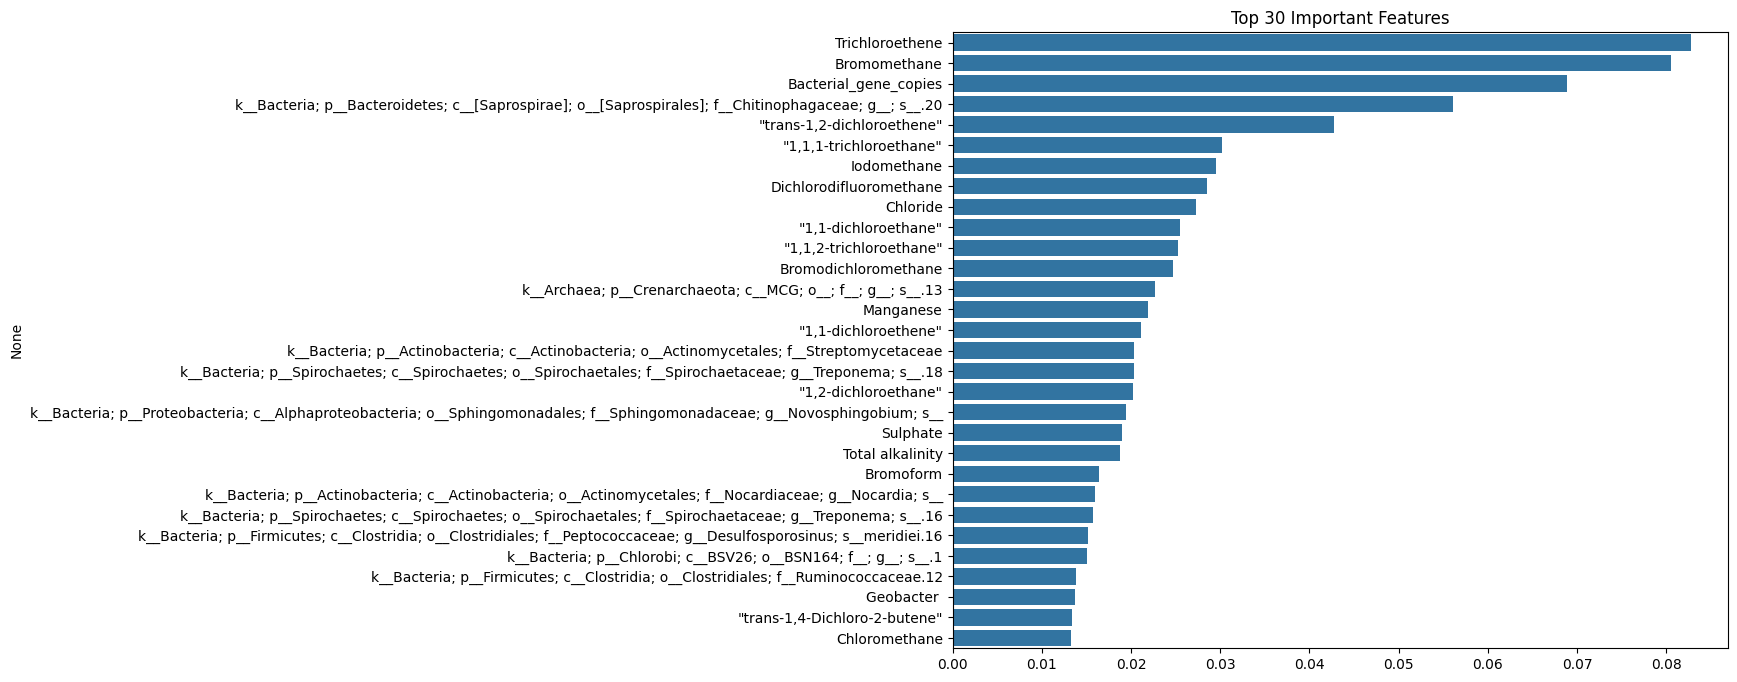

In [373]:
import matplotlib.pyplot as plt
import seaborn as sns

# 对特征重要性进行排序，并选择前30个最重要的特征进行可视化
sorted_idx = np.argsort(feature_importances)[::-1]
top_idx = sorted_idx[:30]

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_idx], y=feature_names[top_idx])
plt.title('Top 30 Important Features')
plt.show()
